In [1]:
# ============================
# INSTALLATION
# ============================

# Install spaCy (compatible with SciSpacy 0.5.1)
!pip install spacy==3.5.3

# Install SciSpacy 0.5.1 and dependencies
!pip install scispacy==0.5.1 conllu pysbd scikit-learn joblib requests

# Install additional dependencies
!pip install gensim tqdm transformers matplotlib seaborn

# Download spaCy's en_core_web_md model
!python -m spacy download en_core_web_md

# Install SciSpacy’s en_core_sci_md model
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_md-0.5.1.tar.gz

# Install SciSpacy’s en_ner_bc5cdr_md (diseases & chemicals)
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz

  Using cached scispacy-0.5.1-py3-none-any.whl.metadata (15 kB)
  Using cached spacy-3.4.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (24 kB)
  Using cached nmslib-2.1.1.tar.gz (188 kB)
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.6.1-py2.py3-none-any.whl.metadata (8.7 kB)
Using cached scispacy-0.5.1-py3-none-any.whl (44 kB)
Using cached spacy-3.4.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.4 MB)
Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for nmslib
  Running setup.py clean for nmslib
Failed to build nmslib
ERROR: Failed to build installable wheels for some pyproject.toml based projects (nmslib)
2025-02-25 04:41:42.265885: E external/local_xla/x

In [2]:
# ============================
# IMPORTS & SETUP
# ============================

import pandas as pd
import numpy as np
import spacy
import scispacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from tqdm import tqdm
from collections import Counter
import re
import torch
from transformers import AutoTokenizer, AutoModel, pipeline  # Note: pipeline imported here
from spacy import displacy
from IPython.display import HTML, display
from sklearn.metrics.pairwise import cosine_similarity

# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Paths to MIMIC data
path_diagnoses_icd = "/content/drive/MyDrive/MIMIC/DIAGNOSES_ICD.csv.gz"
path_noteevents = "/content/drive/MyDrive/MIMIC/NOTEEVENTS.csv.gz"

# ICD-9 Codes for Sepsis
sepsis_codes = ["99591", "99592", "0389"]

Mounted at /content/drive


In [3]:
# ============================
# DATA EXTRACTION
# ============================

# Load datasets
diag_df = pd.read_csv(path_diagnoses_icd, low_memory=True)
note_df = pd.read_csv(path_noteevents, low_memory=True)

# Extract subject IDs diagnosed with sepsis
selected_subjs = diag_df.loc[diag_df['ICD9_CODE'].isin(sepsis_codes), 'SUBJECT_ID'].unique()
print(f"Number of unique sepsis patients: {len(selected_subjs)}")

# Filter discharge summaries
patients_df = note_df[(note_df['SUBJECT_ID'].isin(selected_subjs)) & (note_df['CATEGORY'] == 'Discharge summary')][['SUBJECT_ID', 'CATEGORY', 'TEXT']]
print(f"Total discharge summaries for sepsis: {len(patients_df)}")

# Limit dataset to 500 records
patients_df = patients_df.sample(n=min(500, len(patients_df)), random_state=42)
print(f"Sampled down to {len(patients_df)} notes.")

<ipython-input-3-85e82100d70e>:7: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  note_df = pd.read_csv(path_noteevents, low_memory=True)


Number of unique sepsis patients: 5109
Total discharge summaries for sepsis: 10199
Sampled down to 500 notes.


In [4]:
# ============================
# LOAD NLP MODELS
# ============================

print("Loading NLP models...")

# Standard SpaCy model
nlp_spacy = spacy.load("en_core_web_md")

# SciSpacy models
nlp_sci_md = spacy.load("en_core_sci_md")
nlp_sci_bc5cdr = spacy.load("en_ner_bc5cdr_md")

Loading NLP models...


/usr/local/lib/python3.11/dist-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_md' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [5]:
# ============================
# HELPER FUNCTIONS
# ============================

def preprocess_text(text):
    """Clean medical notes by removing placeholder brackets, converting to lowercase, and stripping spaces."""
    return re.sub(r"\[\*\*.*?\*\*\]", "", text).lower().strip() if isinstance(text, str) else ""

def extract_ents(doc):
    """Extract entity text and labels from a processed SpaCy doc."""
    return [(ent.text.strip().lower(), ent.label_) for ent in doc.ents if len(ent.text.strip()) > 2]

def create_word2vec(list_of_token_lists):
    """Train a Word2Vec model on a list of token lists (entities)."""
    return Word2Vec(sentences=list_of_token_lists, vector_size=100, window=5, min_count=2, workers=4)

def show_displacy(doc):
    """Display entity visualization using displacy."""
    ent_html = displacy.render(doc, style="ent", jupyter=True)
    display(HTML(ent_html))

def tsne_plot(model, title="t-SNE Visualization", num_words=50):
    """Generate a t-SNE plot for word embeddings."""

    # Get the list of vocabulary words (limiting to `num_words`)
    vocab = model.wv.index_to_key[:num_words]

    # Retrieve vectors for selected words
    vectors = np.array([model.wv[word] for word in vocab])

    # Set perplexity (must be less than num_words)
    perplexity_value = min(30, num_words - 1) if num_words > 1 else 1

    tsne = TSNE(n_components=2, perplexity=perplexity_value, n_iter=1000, random_state=42)
    coords = tsne.fit_transform(vectors)

    plt.figure(figsize=(12, 8))
    plt.scatter(coords[:, 0], coords[:, 1], alpha=0.6)

    for i, word in enumerate(vocab):
        plt.annotate(word, (coords[i, 0], coords[i, 1]), fontsize=10)

    plt.title(title)
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


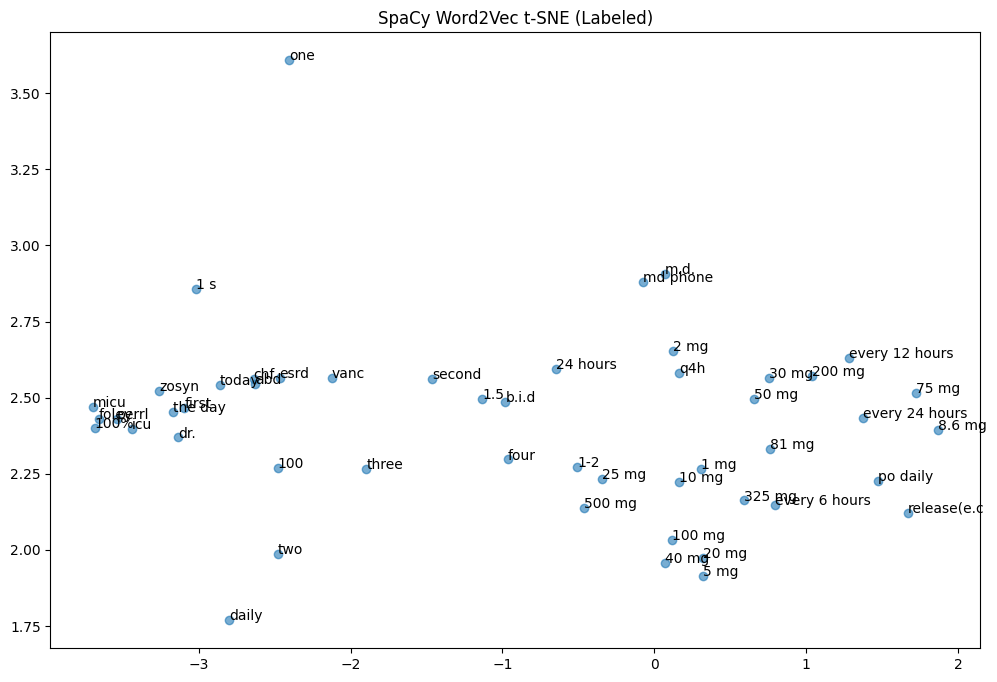

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


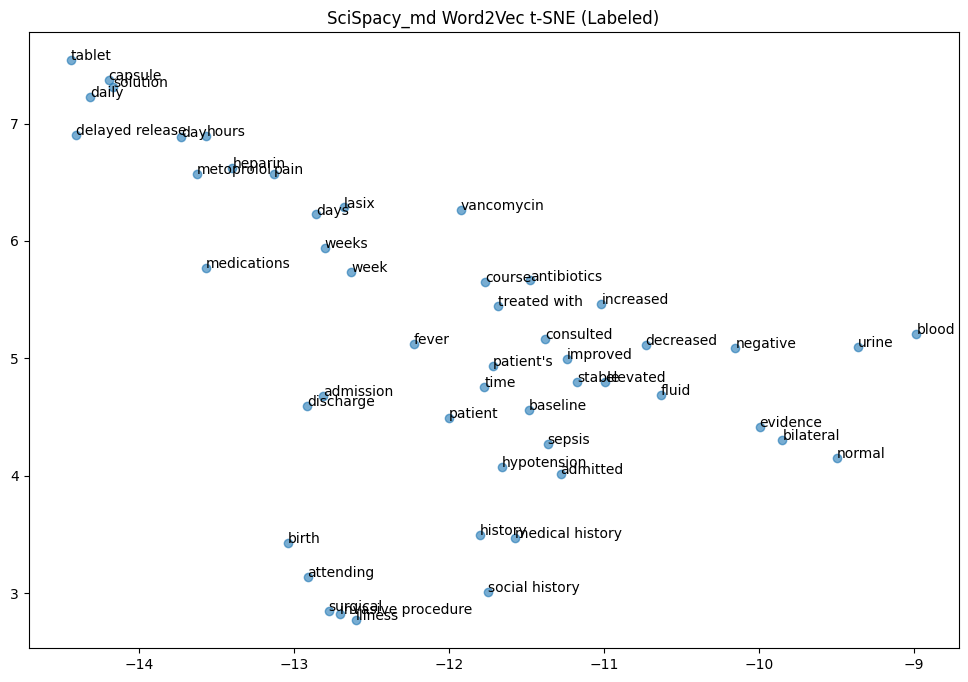

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


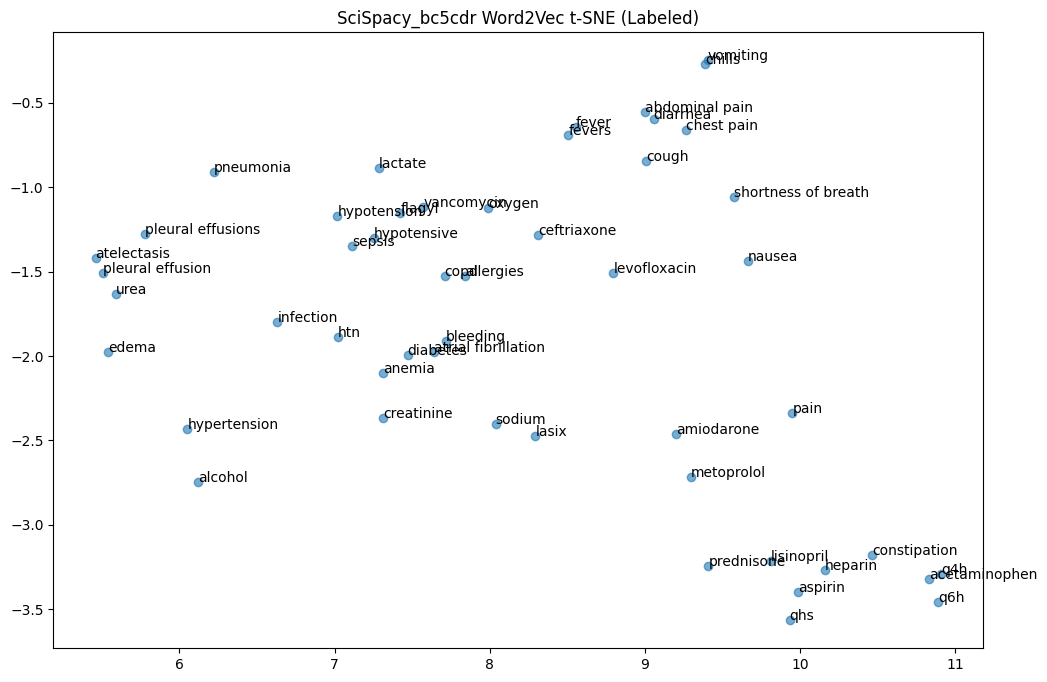

In [6]:
# ============================
# WORD2VEC TRAINING & t-SNE VISUALIZATION
# ============================

# --- Train Word2Vec models on extracted entities from different NLP pipelines ---

# Using standard SpaCy
spacy_corpus = [[word for word, label in extract_ents(nlp_spacy(preprocess_text(row['TEXT'])))]
                for _, row in patients_df.iterrows()]
w2v_spacy = create_word2vec(spacy_corpus)

# Using SciSpacy (en_core_sci_md)
sci_md_corpus = [[word for word, label in extract_ents(nlp_sci_md(preprocess_text(row['TEXT'])))]
                 for _, row in patients_df.iterrows()]
w2v_sci_md = create_word2vec(sci_md_corpus)

# Using SciSpacy (en_ner_bc5cdr_md)
bc5cdr_corpus = [[word for word, label in extract_ents(nlp_sci_bc5cdr(preprocess_text(row['TEXT'])))]
                 for _, row in patients_df.iterrows()]
w2v_bc5cdr = create_word2vec(bc5cdr_corpus)


# --- Generate t-SNE plots for each Word2Vec model ---
tsne_plot(w2v_spacy, "SpaCy Word2Vec t-SNE (Labeled)")
tsne_plot(w2v_sci_md, "SciSpacy_md Word2Vec t-SNE (Labeled)")
tsne_plot(w2v_bc5cdr, "SciSpacy_bc5cdr Word2Vec t-SNE (Labeled)")


In [7]:
# Extract entities from a sample text
sample_text = preprocess_text(patients_df.iloc[0]['TEXT'])

# Process with SpaCy and SciSpacy models
doc_spacy = nlp_spacy(sample_text)
doc_sci_md = nlp_sci_md(sample_text)
doc_bc5cdr = nlp_sci_bc5cdr(sample_text)

# Print extracted entities
print("Entities from en_core_web_md (SpaCy):", extract_ents(doc_spacy))
print("Entities from en_core_sci_md (SciSpacy):", extract_ents(doc_sci_md))
print("Entities from en_ner_bc5cdr_md (SciSpacy_bc5cdr):", extract_ents(doc_bc5cdr))


Entities from en_core_web_md (SpaCy): [('first', 'ORDINAL'), ('about 5 days ago', 'DATE'), ('the night', 'TIME'), ('all night', 'TIME'), ('600', 'CARDINAL'), ('2400', 'CARDINAL'), ('102', 'CARDINAL'), ('2.4', 'CARDINAL'), ('unasyn', 'GPE'), ('ercp', 'ORG'), ('the evening', 'TIME'), ('orthopnea', 'GPE'), ('hematochezia', 'NORP'), ('melena', 'ORG'), ('myalgias', 'PERSON'), ('arthralgias.', 'GPE'), ('70 pounds', 'QUANTITY'), ('several\nyears ago', 'DATE'), ('40 pounds', 'QUANTITY'), ('one', 'CARDINAL'), ('100.6 5% on 40%', 'PERCENT'), ('normal s1, s2', 'GPE'), ('abd', 'PERSON'), ('sclerae anciteric', 'ORG'), ('r.\nabd', 'PERSON'), ('hct-38.6*\nmcv-91', 'ORG'), ('neuts-81', 'GPE'), ('chloride-99', 'FAC'), ('gap-14\n 09:38pm', 'PERSON'), ('lipase-84', 'CARDINAL'), ('hyperdense', 'ORG'), ('bibasilar retrocardiac opacities', 'PERSON'), ('first', 'ORDINAL'), ('ercp', 'ORG'), ('ercp', 'ORG'), ('one', 'CARDINAL'), ('argatroban', 'ORG'), ('vanc', 'ORG'), ('the next\nfew days', 'DATE'), ('vanc agi

In [8]:
# ============================
# DISPLACY VISUALIZATION FOR FIRST NOTE (FORMATTED TEXT)
# ============================

def format_text_for_displacy(text, line_length=120):
    """Formats text to remove excessive new lines and add a new line after reaching `line_length` characters."""
    import re
    text = re.sub(r'\s+', ' ', text).strip()  # Remove excessive spaces and new lines
    words = text.split()  # Split into words
    formatted_text = ""
    current_length = 0

    for word in words:
        if current_length + len(word) + 1 > line_length:
            formatted_text += "\n"  # Insert new line when reaching max length
            current_length = 0
        formatted_text += word + " "
        current_length += len(word) + 1

    return formatted_text.strip()

# ANSI color codes
RED = "\033[91m"
RESET = "\033[0m"

# Preprocess and format the first note
raw_text = preprocess_text(patients_df.iloc[0]['TEXT'])
formatted_text = format_text_for_displacy(raw_text, line_length=120)

# Process the text with each NLP model
doc_spacy = nlp_spacy(formatted_text)
doc_sci_md = nlp_sci_md(formatted_text)
doc_bc5cdr = nlp_sci_bc5cdr(formatted_text)

# Display Displacy visualizations with separation lines and RED titles
print(f"\n-------------- {RED}Displacy visualization for SpaCy (en_core_web_md){RESET} --------------")
show_displacy(doc_spacy)

print(f"\n-------------- {RED}Displacy visualization for SciSpacy (en_core_sci_md){RESET} --------------")
show_displacy(doc_sci_md)

print(f"\n-------------- {RED}Displacy visualization for SciSpacy (en_ner_bc5cdr_md){RESET} --------------")
show_displacy(doc_bc5cdr)

print(f"\n-------------- {RED}End of Displacy Visualizations{RESET} --------------\n")



-------------- Displacy visualization for SpaCy (en_core_web_md) --------------


<IPython.core.display.HTML object>


-------------- Displacy visualization for SciSpacy (en_core_sci_md) --------------


<IPython.core.display.HTML object>


-------------- Displacy visualization for SciSpacy (en_ner_bc5cdr_md) --------------


<IPython.core.display.HTML object>


-------------- End of Displacy Visualizations --------------



config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

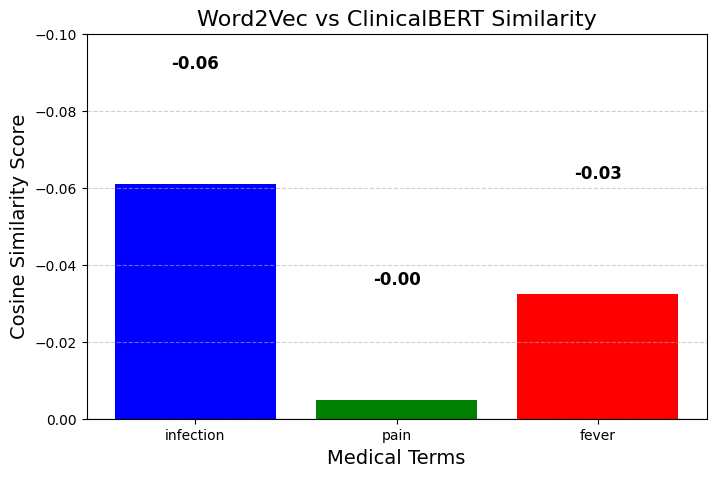

In [13]:
# ============================
# CLINICALBERT EMBEDDING & SIMILARITY COMPARISON (FINAL VERSION)
# ============================

# Load ClinicalBERT model
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name, force_download=True)
clinicalbert_model = AutoModel.from_pretrained(model_name, force_download=True)

def get_cbert_embedding(text):
    """Generate ClinicalBERT embeddings for a given text and reduce it to 100D."""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = clinicalbert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()[:100].reshape(1, -1)  # Reduce to 100D

def compute_similarity(word):
    """Compute cosine similarity between Word2Vec (bc5cdr) and ClinicalBERT embeddings."""
    if word in w2v_bc5cdr.wv:
        w2v_vec = w2v_bc5cdr.wv[word].reshape(1, -1)
        cbert_vec = get_cbert_embedding(word)
        return cosine_similarity(w2v_vec, cbert_vec)[0][0]
    return None

# List of words to compare
words = ["infection", "pain", "bacteria", "fever"]

# Compute similarity scores
similarities = [compute_similarity(word) for word in words]

# Filter out None values (if words were missing in Word2Vec)
filtered_words = [words[i] for i in range(len(similarities)) if similarities[i] is not None]
filtered_similarities = [sim for sim in similarities if sim is not None]

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(filtered_words, filtered_similarities, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel("Medical Terms", fontsize=14)
plt.ylabel("Cosine Similarity Score", fontsize=14)
plt.title("Word2Vec vs ClinicalBERT Similarity", fontsize=16)
plt.ylim(0, -0.1)  # **Fixed Y-axis range**
plt.axhline(0, color='black', linewidth=0.8)  # Add baseline at 0
plt.grid(axis='y', linestyle="--", alpha=0.6)

# Display values on top of bars
for i, v in enumerate(filtered_similarities):
    plt.text(i, v + 0.01 if v >= 0 else v - 0.03, f"{v:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.show()